In [1]:
import os
import keras
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit

from data import read_crop_list, load_structured_sample
from eval import eval_model_one_hot
from metrics import f1, f1_loss
from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from training import train, create_training_folder, create_callbacks, step_decay_exp


from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import concatenate, Embedding, LSTM, BatchNormalization, Dense, \
    Conv1D, GlobalAveragePooling1D, Dropout, Input, Permute, Concatenate, GlobalMaxPooling1D, MaxPooling1D, \
    Flatten, Activation, Reshape,SpatialDropout1D, Add, MaxPooling1D


from training import train, create_training_folder


Using TensorFlow backend.


In [2]:
def load_model(file_name):
    loaded_model = keras.models.load_model(file_name)
    return loaded_model

In [3]:
# model = tf.keras.models.load_model('/home/gus/workspaces/wpy/IACapstone/results/tcn/20200802_085010_64/model')

In [4]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [5]:

df_crops, vocab = read_crop_list()

sample = load_structured_sample()
# sample = load_undersampled_data()
print("Using sample size: {}".format(sample.shape))

y = sample[:, 11]
X = sample[:, 3:11]
sequence_length = X.shape[-1]

# X = one_hot_encoding_X(X, vocab_size=vocab_size)
y = to_categorical(y)
# random train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# y_train = to_categorical(y_train, num_classes=vocab_size)
# y_test = to_categorical(y_test, num_classes=vocab_size)

print(np.unique(y_train).shape)

print("===Train/test size: {}, {}".format(len(y_train), len(y_test)))

Using sample size: (31373, 12)
(2,)
===Train/test size: 21961, 9412


In [6]:
X.shape

(31373, 8)

In [7]:
crop_names = df_crops["description"].values.tolist()
crop_list = df_crops["idx"].values.tolist()

In [8]:
np.unique(X)
np.unique(y)

df_crops

# model = load_model('../results/20200719_181629_lstm_64_64')


,code,description,is_crop,idx
0,1,TRIGO,1,0
1,3,URBANO-VIALES,0,1
2,4,MAIZ,1,2
3,5,CEBADA,1,3
4,8,OTROS CEREALES,1,4
5,9,ROQUEDOS,0,5
6,20,SUELO DESNUDO,1,6
7,33,GIRASOL,1,7
8,35,COLZA,1,8
9,39,OTRAS LEGUMINOSAS GRANO,1,9


In [9]:
# y_pred = model.predict(X_test)

# class_test = np.argmax(y_test, axis=1)
# class_predicted = np.argmax(y_pred,crop_names axis=1)

# # eval_model(folder, class_predicted, class_test, classes, labels)
# np.unique(class_predicted)

In [10]:
def model_Conv1D(sequence_length, embeddings):
    vocab_size, embedding_size = embeddings
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_size,
                        input_length=sequence_length))
    model.add(Conv1D(filters=32, kernel_size=2, strides=1, activation='relu'))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=32, kernel_size=5, strides=1, activation='relu'))
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(4))
# #     model.add(Dropout(0.5))
#     model.add(GlobalMaxPooling1D())
#     model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(vocab_size, activation='relu'))
    model.add(Dense(vocab_size, activation='relu'))
    return model

def model_Rest_Stacked_lstm(sequence_length, embeddings):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))
    embeddings = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    conv1 = Conv1D(filters=128, kernel_size=2, padding="same", strides=1, activation='relu')(embeddings)
    conv2 = Conv1D(filters=128, kernel_size=4, padding="same", strides=1, activation='relu')(embeddings)
    # # conv3 = Conv1D(filters=32, kernel_size=7, padding="same", strides=1, activation='relu')(embeddings)
#     lstm1 = LSTM(64, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(embeddings)

    concat = Concatenate(axis=2)([conv1, conv2, embeddings])
    concat = Dropout(0.3)(concat)
    lstm2 = LSTM(64, dropout=0.3, recurrent_dropout=0.2)(concat)

    btch = BatchNormalization()(lstm2)
    output = Dense(vocab_size, activation='relu')(btch)
    # output = concat
    model = Model(input, output, name="conv-lstm_parallel")
    # tag = "conv_lstm_restnet"
    return model    


def hydrid(sequence_length, embeddings):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))
    embeddings1 = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    input2 = Input(shape=(sequence_length,))
    embeddings2 = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    input3 = Input(shape=(sequence_length,))
    embeddings3 = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    # conv
    conv1 = Conv1D(filters=64, kernel_size=3, padding="same", strides=1, activation='relu')(embeddings1)
    conv2 = Conv1D(filters=66, kernel_size=4, padding="same", strides=1, activation='relu')(embeddings2)
    lstm = LSTM(128, dropout=0.3, recurrent_dropout=0.4, return_sequences=True)(embeddings3)
    # # conv3 = Conv1D(filters=32, kernel_size=7, padding="same", strides=1, activation='relu')(embeddings)

    concat = Concatenate(axis=2)([conv1, conv2, lstm])
    
#     concat = Dropout(0.3)(concat)
    lstm2 = LSTM(128, dropout=0.3, recurrent_dropout=0.4)(concat)

    btch = BatchNormalization()(lstm2)
    output = Dense(vocab_size, activation='relu')(btch)
    # output = concat
    model = Model(input, output, name="conv-lstm_parallel")
    # tag = "conv_lstm_restnet"
    return model   

def basic_lstm(sequence_length, embeddings):
    input = Input(shape=(sequence_length,))
    embeddings = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)
    lstm = LSTM(128, dropout=0.3, recurrent_dropout=0.5)(embeddings)
    btch = BatchNormalization()(lstm)
    output = Dense(vocab_size, activation='relu')(btch)
    # output = concat
    model = Model(input, output)
    # tag = "conv_lstm_restnet"
    return model   


def lstm_conv(sequence_length, embeddings):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))
    embeddings1 = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    input2 = Input(shape=(sequence_length,))
    embeddings2 = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    input3 = Input(shape=(sequence_length,))
    embeddings3 = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)

    # conv
#     conv1 = Conv1D(filters=64, kernel_size=3, padding="same", strides=1, activation='relu')(embeddings1)
# #     conv1 = Flatten()(conv1)
    conv2 = Conv1D(filters=64, kernel_size=3, padding="same", strides=1, activation='relu')(embeddings2)
    conv2 = Dense(8)(conv2)
    lstm = LSTM(128, dropout=0.3, recurrent_dropout=0.4, return_sequences=True)(embeddings3)
    # # conv3 = Conv1D(filters=32, kernel_size=7, padding="same", strides=1, activation='relu')(embeddings)

    concat = Concatenate(axis=2)([conv2, lstm])
    
#     concat = Dropout(0.3)(concat)
    dense = Dense(512, activation='relu')(concat)
    flatten = Flatten()(dense)
#     btch = BatchNormalization()(dense)
    output = Dense(vocab_size, activation='relu')(flatten)
    # output = concat
    model = Model(input, output, name="conv-lstm_parallel")
    # tag = "conv_lstm_restnet"
    return model   


def basic_lstm_conv(sequence_length, embeddings):
    input = Input(shape=(sequence_length,))
    
    embeddings = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)
    lstm = LSTM(128, dropout=0.3, recurrent_dropout=0.5, return_sequences=True)(embeddings)
#     btch = BatchNormalization()(lstm)
    conv = Conv1D(filters=64, kernel_size=3, padding="same", strides=1, activation='relu')(lstm)
#     conv = BatchNormalization()(lstm)
    flatten = Flatten()(conv)

    output = Dense(vocab_size, activation='relu')(flatten)
    
    model = Model(input, output)
    # tag = "conv_lstm_restnet"
    return model   



from tensorflow.python.keras.regularizers import l2
def lstmfcn(sequence_length, embeddings, layer_size = 64):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))

    x = Embedding(vocab_size, embedding_size,input_length=sequence_length)(input)
    x_conv = Conv1D(filters=32, kernel_size=3, padding="same", strides=1, activation='relu')(x)
    x = Concatenate(axis=2)([x, x_conv])
    x = LSTM(128, recurrent_dropout=0.4, recurrent_regularizer=l2(0.001))(x)  # lstm block
    x = Dropout(0.5)(x)

    # permutes the first and second dimension of the input (connecting RNNs and convnets together)
    y = Embedding(vocab_size, 27,input_length=sequence_length)(input)
    y = Permute((2, 1))(y)

    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)  # for temporal convolution
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(0.5)(y)
    
    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(vocab_size, activation='relu')(x)  # classification

    model = Model(input, out)
    model.summary()

    return model

def fcn(sequence_length, embeddings, layer_size = 64):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))

    # permutes the first and second dimension of the input (connecting RNNs and convnets together)
    y = Embedding(vocab_size, embedding_size,input_length=sequence_length)(input)
    y = Permute((2, 1))(y)

    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)  # for temporal convolution
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(0.5)(y)
    
    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)

    out = Dense(vocab_size, activation='relu')(y)  # classification

    model = Model(input, out)
    model.summary()

    return model


def basic_lstm_flatten(sequence_length, embeddings):
    input = Input(shape=(sequence_length,))
    embeddings = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)
    embeddings = Flatten()(embeddings)
    embeddings = Reshape((-1, embedding_size))(embeddings)
    lstm = LSTM(128, dropout=0.3, recurrent_dropout=0.5)(embeddings)
    btch = BatchNormalization()(lstm)
    output = Dense(vocab_size, activation='relu')(btch)
    # output = concat
    model = Model(input, output)
    # tag = "conv_lstm_restnet"
    return model   


def lstm_conv1_mutibranch(sequence_length, embeddings, layer_size=64):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))

    conv_emb = Embedding(vocab_size, embedding_size, input_length=sequence_length)(input)

    conv2 = Conv1D(64, 2, padding='same')(conv_emb)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)

    conv3 = Conv1D(64, 3, padding='same')(conv_emb)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    conv5 = Conv1D(64, 5, padding='same')(conv_emb)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    conv_add = Add()([conv2, conv3, conv5])
    conv_add = Concatenate(axis=2)([conv_add, conv_emb])

    lstm_emb = Embedding(vocab_size, embedding_size, input_length=sequence_length)(input)
    lstm = SpatialDropout1D(0.3)(lstm_emb)
    lstm = LSTM(units=64, recurrent_dropout=0.3, return_sequences=True)(lstm)
    lstm = BatchNormalization()(lstm)
    lstm = Dropout(0.3)(lstm)

    x = Concatenate(axis=2)([conv_add, lstm])
#     x = BatchNormalization()(x)
#     x = Activation(activation='relu')(x)

#     x = SpatialDropout1D(0.3)(x)
    x = LSTM(units=128, recurrent_dropout=0.3, return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Flatten()(x)

    output = Dense(vocab_size, activation='relu')(x)
    
    return Model(input, output)



def inception(input):
    conv1 = Conv1D(32, 2, padding='same', activation="relu")(input)
    conv2 = Conv1D(32, 3, padding='same', activation="relu")(input)
    conv3 = Conv1D(32, 5, padding='same', activation="relu")(input)

#     pool = MaxPooling1D(2, strides=1, padding='same')(input)
#     conv4 = Conv1D(32, 1, padding='same')(pool)

    output = Concatenate(axis=2)([conv1, conv2, conv3])
    output = SpatialDropout1D(0.3)(output)
    return output



def lstm_inception(sequence_length, embeddings, layer_size=64):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))

    conv_emb = Embedding(vocab_size, embedding_size, input_length=sequence_length)(input)
    
    x = inception(conv_emb)
    x = inception(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)


    lstm_emb = Embedding(vocab_size, embedding_size, input_length=sequence_length)(input)
    lstm = SpatialDropout1D(0.3)(lstm_emb)
    lstm = LSTM(units=64, recurrent_dropout=0.3, return_sequences=True)(lstm)

    x = Concatenate(axis=2)([x, lstm])
#     x = BatchNormalization()(x)
#     x = Activation(activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Activation('relu')(x)

#     x = SpatialDropout1D(0.3)(x)
    x = LSTM(units=256, recurrent_dropout=0.3, return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Flatten()(x)

    output = Dense(vocab_size, activation='relu')(x)
    
    return Model(input, output)
    

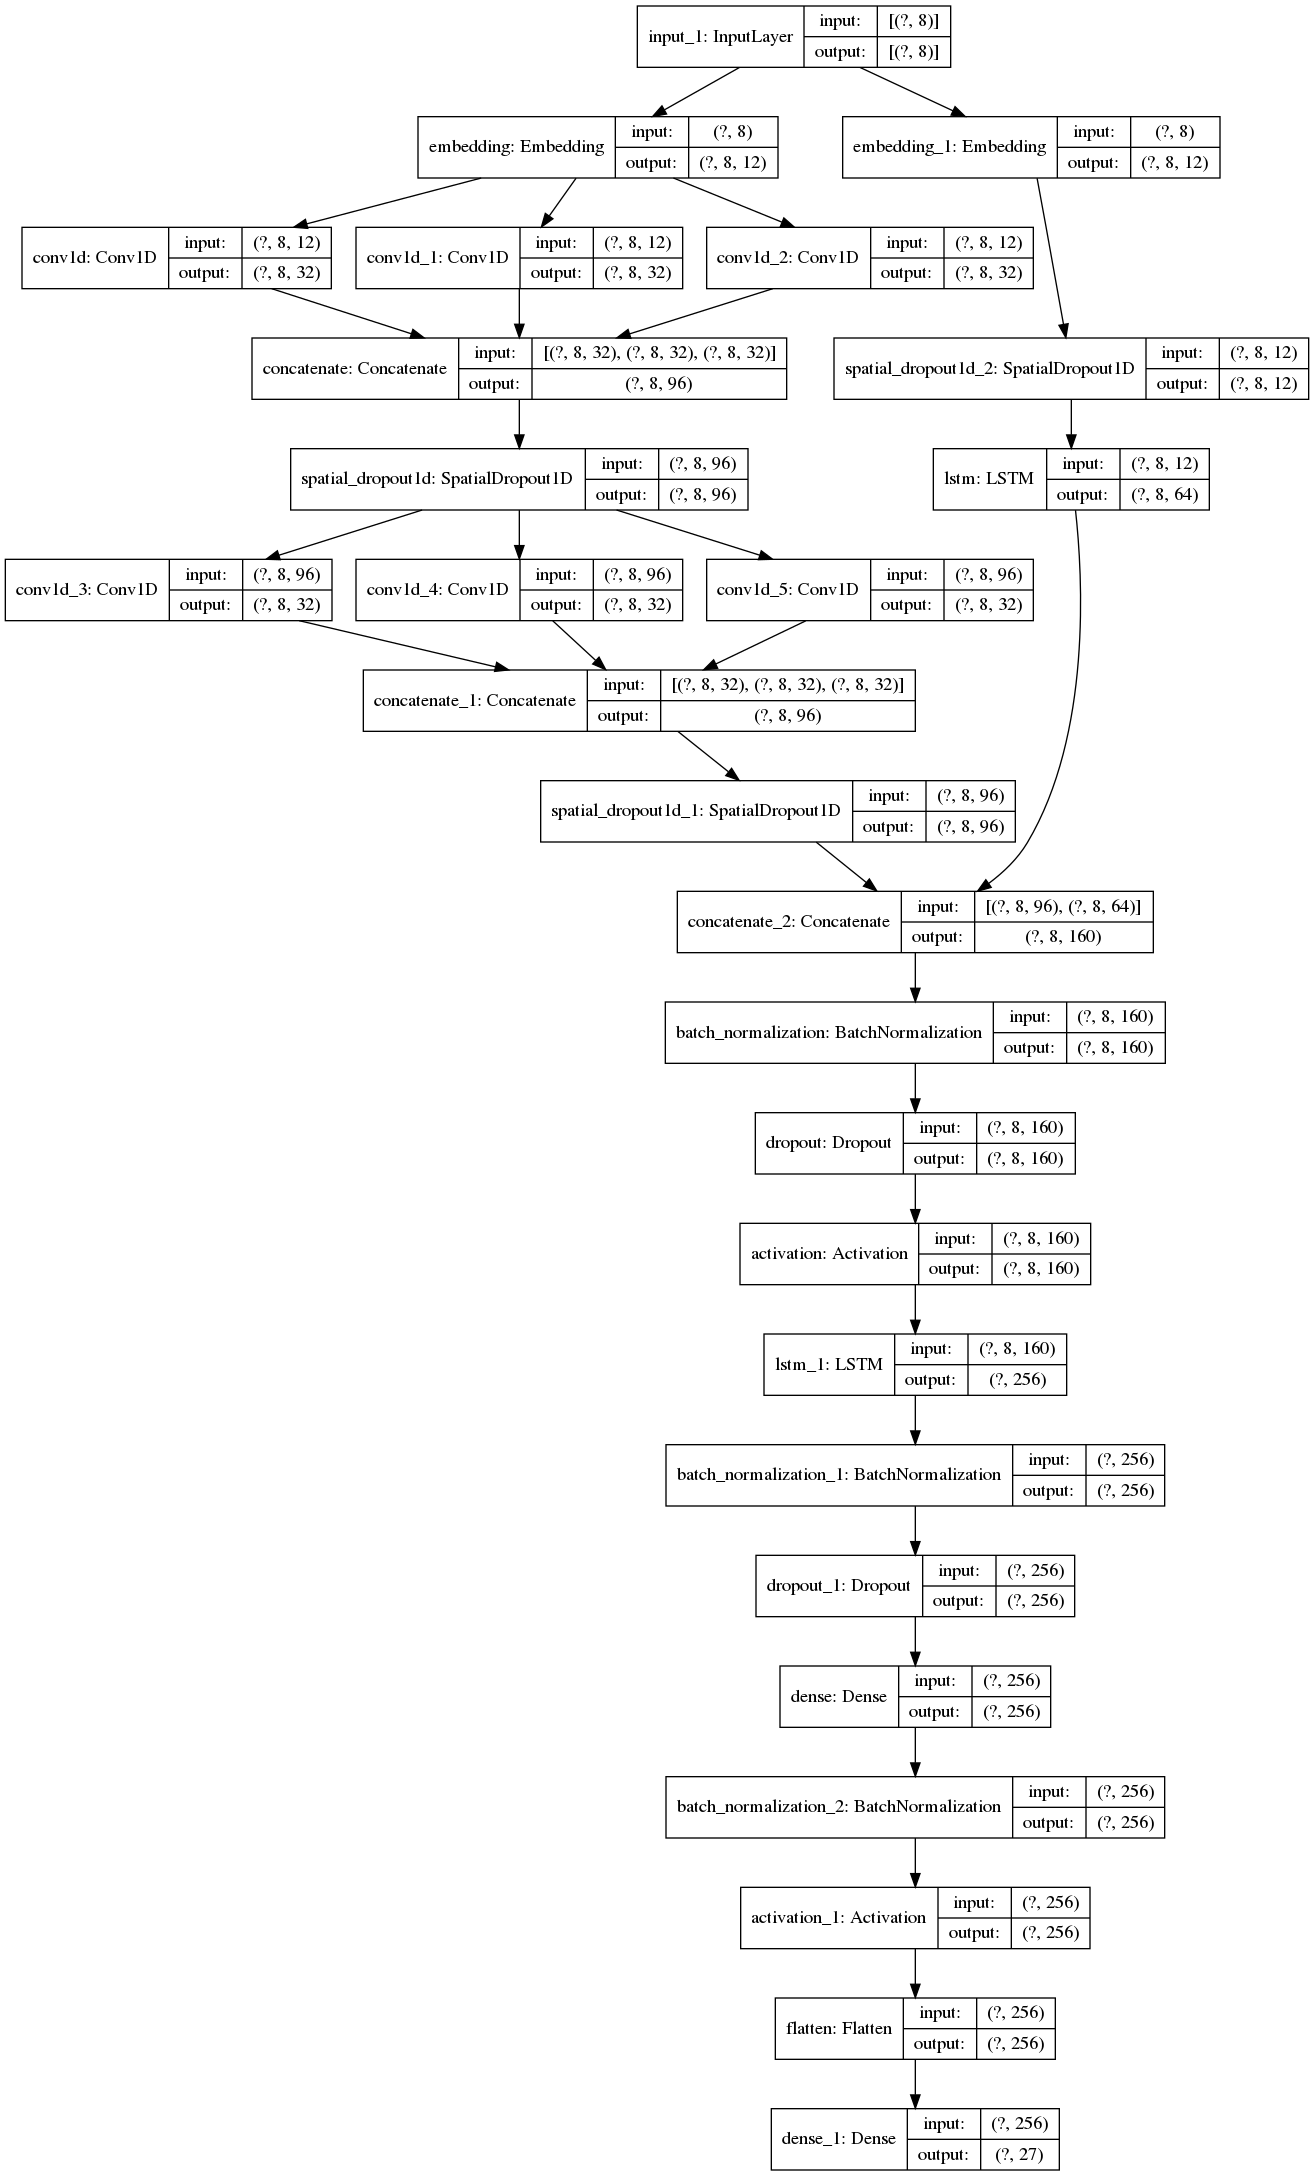

In [11]:

# K.clear_session()
sequence_length = 8
vocab_size, embedding_size = (27, 12)
# model = hydrid(sequence_length, (vocab_size, embedding_size))
model = lstm_inception(sequence_length, (vocab_size, embedding_size))

tag = "conv_rest_stacked"

tf.keras.utils.plot_model(model, show_shapes = True)

In [12]:


# sequence_length = 8

# vocab_size, embedding_size = (28, 5)
# layer_size = (64, 32)
# final_activation = "relu"

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_size,
#                     input_length=sequence_length))
# return_sequences = True
# for i, units in enumerate(layer_size):
#     if i == len(layer_size) - 1:  # last layer
#         return_sequences = False
#     model.add(LSTM(units, dropout=0.3, recurrent_dropout=0.4,
#                    activation='relu', return_sequences=return_sequences))
# model.add(BatchNormalization())
# model.add(Dense(vocab_size, activation=final_activation))
# tag = "conv_lstm_128_64"

In [13]:
# tf.keras.backend.clear_session()

training_params = {
    'loss': f1_loss,
    'optimizer': 'rmsprop',
    'metrics': [f1],
    'run_eagerly': False
}

model.compile(**training_params)

epochs=100
exp_base = "conv1d"
folder = create_training_folder(exp_base, tag)

lr_scheduller = tf.keras.callbacks.LearningRateScheduler(step_decay_exp)
#lr_scheduller = tf.keras.callbacks.ReduceLROnPlateau(step_decay_exp)
lr_scheduller = None
callbacks = create_callbacks(folder, tensor_board=True, monitor_metric="val_f1", monitor_mode="max",
                     lr_scheduller=lr_scheduller)


train(model, X_train, y_train, X_test, y_test, epochs=epochs, callbacks=callbacks)

# save model
model_folder = '{}/model'.format(folder)
model.save(model_folder)


Epoch 1/100

Epoch 00001: val_f1 improved from -inf to 0.58944, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_184041_conv_rest_stacked
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_184041_conv_rest_stacked/assets
687/687 - 34s - loss: 0.4827 - f1: 0.5179 - val_loss: 0.4096 - val_f1: 0.5894
Epoch 2/100

Epoch 00002: val_f1 improved from 0.58944 to 0.65302, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_184041_conv_rest_stacked
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_184041_conv_rest_stacked/assets
687/687 - 34s - loss: 0.3664 - f1: 0.6334 - val_loss: 0.3451 - val_f1: 0.6530
Epoch 3/100

Epoch 00003: val_f1 improved from 0.65302 to 0.66835, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_184041_conv_rest_stacked
INFO:ten

Epoch 35/100

Epoch 00035: val_f1 did not improve from 0.73426
687/687 - 53s - loss: 0.2249 - f1: 0.7744 - val_loss: 0.2699 - val_f1: 0.7279
Epoch 36/100

Epoch 00036: val_f1 did not improve from 0.73426
687/687 - 54s - loss: 0.2218 - f1: 0.7777 - val_loss: 0.2687 - val_f1: 0.7293
Epoch 37/100

Epoch 00037: val_f1 improved from 0.73426 to 0.73591, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_184041_conv_rest_stacked
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_184041_conv_rest_stacked/assets
687/687 - 50s - loss: 0.2251 - f1: 0.7744 - val_loss: 0.2619 - val_f1: 0.7359
Epoch 38/100

Epoch 00038: val_f1 did not improve from 0.73591
687/687 - 29s - loss: 0.2225 - f1: 0.7769 - val_loss: 0.2635 - val_f1: 0.7345
Epoch 39/100

Epoch 00039: val_f1 did not improve from 0.73591
687/687 - 29s - loss: 0.2197 - f1: 0.7796 - val_loss: 0.2730 - val_f1: 0.7248
Epoch 40/100

Epoch 00040: val_f1 did not improve from 0.73591

/home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Confusion matrix, without normalization


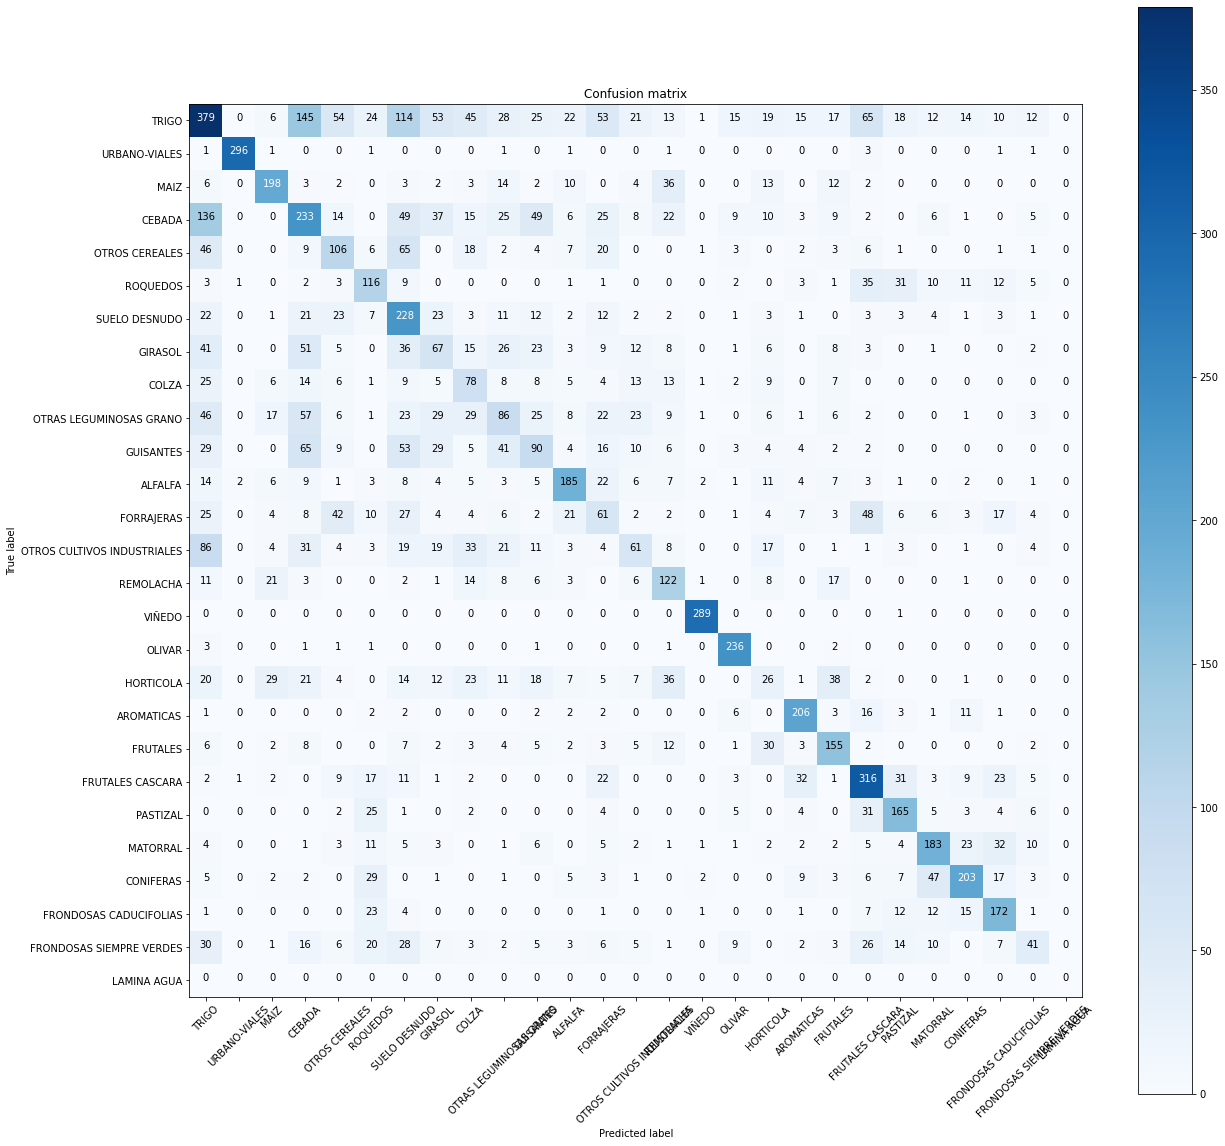

In [14]:

# evaluate
y_hat = model.predict(X_test)
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)


